In [1]:
#Loading in our data
!wget https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Gift_Cards_5.json.gz --no-check-certificate
!wget https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Gift_Cards.csv --no-check-certificate
!gzip -d Gift_Cards_5.json.gz
!head Gift_Cards_5.json
!head Gift_Cards.csv
!wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/metaFiles2/meta_Gift_Cards.json.gz --no-check-certificate
!gzip -d meta_Gift_Cards.json.gz
!head meta_Gift_Cards.json

--2023-11-07 10:41:30--  https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Gift_Cards_5.json.gz
Resolving jmcauley.ucsd.edu (jmcauley.ucsd.edu)... 137.110.160.73
Connecting to jmcauley.ucsd.edu (jmcauley.ucsd.edu)|137.110.160.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 176952 (173K) [application/x-gzip]
Saving to: ‘Gift_Cards_5.json.gz’

Gift_Cards_5.json.g 100%[===================>] 172.80K  --.-KB/s    in 0.02s   

2023-11-07 10:41:30 (7.94 MB/s) - ‘Gift_Cards_5.json.gz’ saved [176952/176952]

--2023-11-07 10:41:30--  https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Gift_Cards.csv
Resolving jmcauley.ucsd.edu (jmcauley.ucsd.edu)... 137.110.160.73
Connecting to jmcauley.ucsd.edu (jmcauley.ucsd.edu)|137.110.160.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6143525 (5.9M) [text/csv]
Saving to: ‘Gift_Cards.csv.1’

Gift_Cards.csv.1    100%[===================>]   5.86M  15.0MB/s    in 0.4s    

2023-11-07 

In [1]:
#Installing packages that do not come pre installed
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
!pip install torch-geometric
!pip install umap-learn

Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
  Using cached torch_scatter-2.1.2.tar.gz (108 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp39-cp39-macosx_11_0_arm64.whl size=268030 sha256=e6f251fa9f1c62a6980349854399a7c2fbc75a25352965f8ba1b45597358068e
  Stored in directory: /Users/aidenchang/Library/Caches/pip/wheels/b8/9c/c0/d261e1e64cc49e6b14dd7319d8b61eb14168529d810dbba00e
Successfully built torch-scatter
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
  Using cached torch_sparse-0.6.18.tar.gz (209 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp39-cp39-macosx_11_0_arm64.whl size=463278 sha256=648402f2557253b592a7e08fbc561f3cd1bbb375b68363cef3ab2f02085bcc8c
  Stored in directory: /Users/aidenchang/Library/Caches/pip/wheels/c0/15/18/881c60adefeb60882987c23aa5ecced0ab7257c3162acab518
Successfully built torch-sparse
  Us

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.6/153.6 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 16.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 41.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 14.3 MB/s eta 0:00:00a 0:00:01


In [5]:
# General libraries
import json
from pathlib import Path as Data_Path
import os
from os.path import isfile, join
import pickle
import random

import numpy as np
import networkx as nx
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

In [4]:
from typing import Optional, Union

import torch
from torch import Tensor
import torch.nn as nn
from torch.nn import Embedding, ModuleList, Linear
import torch.nn.functional as F

import torch_geometric
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch.nn.modules.loss import _Loss

from torch_geometric.nn.conv import LGConv, GATConv, SAGEConv
from torch_geometric.typing import Adj, OptTensor, SparseTensor


print(f"Torch version: {torch.__version__}; Torch-cuda version: {torch.version.cuda}; Torch Geometric version: {torch_geometric.__version__}.")

Torch version: 2.1.0; Torch-cuda version: None; Torch Geometric version: 2.4.0.


In [6]:
# set the seed for reproducibility
seed = 224
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [7]:
##Defining classes

class Product:
  def __init__(self, title, asin, description, also_bought, categories):
    self.title = title #name, string
    self.asin = asin #string
    self.description = description #string
    # self.features = features # String[]
    self.also_bought = also_bought #asin[]
    self.categories = set(categories) #categories[]


  def __str__(self):
    return f"Product {self.title}"

class Category:
  def __init__(self, name):
    self.name = name
    self.products = []

  def add_to_category(self, product):
    self.products.append(product)

  def __str__(self):
    return f"Category {self.name} has {len(self.products)} in it."

class User:
  def __init__(self, reviewerID):
    self.reviewerID = reviewerID
    self.products_reviewed = []
    #maybe we can add the categories that they reviewed?

  def add_to_reviewed(self, product):
    self.products_reviewed.append(product)

  def __str__(self):
    return f"User {self.reviewerID} has reviewed {len(self.products_reviewed)} products"

In [8]:
import pandas as pd
import json

# reviews = pd.read_csv("Gift_Cards.csv")
review_data = []
review_name = 'Gift_Cards_5.json'
with open(review_name, 'r') as file:
    for line in file:
      review_data.append(json.loads(line))
file_metadata = []
metadata_link = "meta_Gift_Cards.json"
with open(metadata_link, 'r') as file:
    for line in file:
      file_metadata.append(json.loads(line))

In [9]:
products = {}
all_categories = {}
users = {}

def process_review_data(review):
  try:
    userID = review['reviewerID']
  except:
    print(review)
  if userID not in users:
    new_user = User(userID)
    users[userID] = new_user
  users[userID].add_to_reviewed(review['asin'])

def process_metadata(metadata):
  asin = metadata['asin']
  # features = metadata['features']
  also_bought = metadata['also_buy']
  description = metadata['description']
  categories = metadata['category']
  title = metadata['title']
  if asin not in products:
    new_product = Product(title, asin, description, also_bought, categories)
    products[asin] = new_product
  for category in categories:
    if category not in all_categories:
      all_categories[category] = Category(category)
    all_categories[category].add_to_category(asin)


def load_data():
  for line in review_data:
    process_review_data(line)
  for line in file_metadata:
    process_metadata(line)


In [10]:
load_data()

In [11]:
import torch
from torch_geometric.data import Data

# Create instances of your classes
# This is just a placeholder. Replace this with your actual data.
# products = [...]
# categories = [...]
# users = [...]

# Create mappings from unique IDs to consecutive integers
unique_user_id = [user for user in users]
unique_user_id = pd.DataFrame(data={
   'userId': unique_user_id,
   'mappedID': pd.RangeIndex(len(unique_user_id)),
})

unique_product_id = [product for product in products]
unique_product_id = pd.DataFrame(data={
   'productId': unique_product_id,
   'mappedID': pd.RangeIndex(len(unique_product_id)),
})

unique_category_id = [category for category in all_categories]
unique_category_id = pd.DataFrame(data={
   'categoryId': unique_category_id,
   'mappedID': pd.RangeIndex(len(unique_category_id)),
})
# print(unique_user_id)
# Construct the edge indices
# User to Product (Review)
user_product_edges = []
for user_name in users:
   user_object = users[user_name]
   for product_id in users[user_name].products_reviewed:
       product = products[product_id]
       user_product_edges.append([unique_user_id.loc[unique_user_id['userId'] == user_object.reviewerID, 'mappedID'].values[0],
                                unique_product_id.loc[unique_product_id['productId'] == product.asin, 'mappedID'].values[0]])
user_product_edges = torch.tensor(user_product_edges, dtype=torch.long)

# Product to Product (Also Bought)
product_product_edges = []
for product_id in products:
   product = products[product_id]
   for also_bought_product in products[product_id].also_bought:
      #  print(also_bought_product)
 
       if (unique_product_id['productId'] == also_bought_product).any():  
         product_product_edges.append([unique_product_id.loc[unique_product_id['productId'] == product.asin, 'mappedID'].values[0],
                                   unique_product_id.loc[unique_product_id['productId'] == also_bought_product, 'mappedID'].values[0]])
# print(len(product_product_edges))
product_product_edges = torch.tensor(product_product_edges, dtype=torch.long)

# Product to Category
product_category_edges = []
for product_id in products:
   product = products[product_id]
   for category in products[product_id].categories:
       product_category_edges.append([unique_product_id.loc[unique_product_id['productId'] == product.asin, 'mappedID'].values[0],
                                    unique_category_id.loc[unique_category_id['categoryId'] == category, 'mappedID'].values[0]])

product_category_edges = torch.tensor(product_category_edges, dtype=torch.long)

In [14]:
print(len(product_product_edges), len(product_category_edges), len(product_category_edges))



5993 3622 3622
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.1/123.1 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 17.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.4/174.4 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.0/291.0 kB 1.5 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 425.9/425.9 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 45.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [21]:
from sentence_transformers import SentenceTransformer

class TextEncoder:
    """
    A class for encoding text using a SentenceTransformer model.
    """
    def __init__(self, model='all-MiniLM-L6-v2', device=None):
        """
        :param model: Name of the SentenceTransformer model to use.
        :param device: Device to use for model inference. Default is None.
        """
        self.device = device
        self.model = SentenceTransformer(model, device=self.device)

    @torch.no_grad()
    def __call__(self, values: list):
        """
        Encode a list of text values into embeddings.

        :param values: List of text values to encode.
        :return: Encoded embeddings as a PyTorch tensor.
        """
        x = self.model.encode(values,
                              show_progress_bar=True,
                              convert_to_tensor=True,
                              device=self.device)
        return x.cpu()


# Check if CUDA is available, and set the device accordingly
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# Create an instance of the TextEncoder class with the determined device
encoder = TextEncoder(device=device)

In [22]:
ex = "I am aiden"
e = encoder(ex)
print(e.shape)


Batches: 100%|██████████| 1/1 [00:00<00:00, 57.09it/s]

torch.Size([384])
torch.Size([384])


In [26]:
products[list(products.keys())[0]].description

['Gift card for the purchase of goods or services at Serendipity 3 in New York City only. Not valid for online purchases.',
 'Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diagnose, treat, cure, or prevent any disease or health condition.']

In [27]:
# Create product features
product_features = torch.zeros((len(unique_product_id), 384))
for product_id in products:
   product = products[product_id]
   mapped_id = unique_product_id.loc[unique_product_id['productId'] == product.asin, 'mappedID'].values[0]
   d = ""
   for descrip in product.description:
      d = d + descrip
   product.description = d
   product_features[mapped_id] = encoder(product.description)

Batches: 100%|██████████| 1/1 [00:00<00:00, 16.66it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 85.35it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.15it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 29.31it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 89.61it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 71.79it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 88.05it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 37.89it/s]

torch.Size([384])



Batches: 100%|██████████| 1/1 [00:00<00:00, 91.09it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 112.23it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 58.68it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 70.84it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 72.69it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 47.66it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 49.53it/s]

torch.Size([384])



Batches: 100%|██████████| 1/1 [00:00<00:00, 60.82it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 43.06it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 68.60it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 47.66it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 18.90it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 57.59it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 56.58it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 79.25it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.73it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 36.44it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 18.33it/s]

torch.Size([384])



Batches: 100%|██████████| 1/1 [00:00<00:00, 80.28it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 74.64it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 49.12it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 48.94it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 51.29it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 95.59it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 74.12it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 48.19it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 22.63it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 66.51it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 74.84it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 119.79it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 66.31it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 52.59it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 98.26it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 108.75it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 105.01it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 127.16it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 117.52it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 120.83it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 114.66it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 122.41it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 135.76it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 120.67it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 116.93it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 24.14it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 101.10it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 108.03it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 97.88it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 116.44it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 126.66it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 104.91it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 36.43it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 75.84it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 88.58it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 113.30it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 103.57it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 57.56it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 80.15it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 73.71it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 88.89it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 104.83it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 96.57it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 115.04it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 76.75it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 90.08it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 64.32it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 99.70it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 71.96it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 86.86it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 53.27it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 76.02it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 112.86it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 79.42it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 110.14it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 86.45it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 106.70it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 90.22it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 110.91it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 102.54it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 96.30it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 16.19it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 106.69it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 109.78it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 103.49it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 112.99it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 91.99it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 94.68it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 86.03it/s]

torch.Size([384])



Batches: 100%|██████████| 1/1 [00:00<00:00, 73.24it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 57.48it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 84.30it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 86.92it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 97.36it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 84.53it/s]

torch.Size([384])



Batches: 100%|██████████| 1/1 [00:00<00:00, 51.79it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 91.66it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 106.80it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 102.06it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 85.39it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 95.95it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 84.83it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 129.69it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 107.57it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 100.12it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 51.09it/s]

torch.Size([384])



Batches: 100%|██████████| 1/1 [00:00<00:00, 35.13it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 53.85it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 85.99it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 85.51it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 59.84it/s]

torch.Size([384])



Batches: 100%|██████████| 1/1 [00:00<00:00, 56.03it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 106.64it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 90.25it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 99.12it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 123.87it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 98.55it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 76.73it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 112.73it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 89.57it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 116.14it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 117.85it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 98.27it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 124.89it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 108.52it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 90.53it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 58.86it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 91.30it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 110.76it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 99.11it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 122.81it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 127.20it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 101.27it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 103.55it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 94.57it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 92.70it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 75.98it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 66.41it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 76.85it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 113.02it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 82.86it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 104.46it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 73.99it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 71.13it/s]

torch.Size([384])



Batches: 100%|██████████| 1/1 [00:00<00:00, 101.91it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 113.49it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 82.85it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 104.85it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 95.15it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 55.99it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 31.10it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 73.47it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 71.98it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 67.04it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 102.26it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 118.72it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 131.32it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 126.50it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 105.13it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 114.09it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 114.71it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 125.39it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 119.76it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 129.36it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 111.23it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 127.46it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 126.01it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 123.39it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 121.43it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 136.88it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 112.79it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 121.15it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 127.81it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 129.67it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 123.53it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 137.21it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 136.97it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 114.00it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 127.55it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 126.12it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 77.61it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 101.94it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 88.01it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 91.19it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 88.88it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 98.21it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 94.90it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 107.30it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 37.41it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 89.56it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 115.46it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 103.11it/s]

torch.Size([384])



Batches: 100%|██████████| 1/1 [00:00<00:00, 112.11it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 86.72it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 58.89it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 108.00it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 105.16it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 103.64it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 104.14it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 100.20it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 110.19it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 102.05it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 112.61it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 79.96it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 84.10it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 89.08it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 105.98it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 102.29it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 129.59it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 94.89it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 62.41it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 68.92it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 24.87it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 57.45it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 106.18it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 60.18it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 81.76it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 48.43it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 67.43it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 116.61it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 70.42it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 86.38it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 105.05it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 72.94it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 54.99it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 43.46it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 76.31it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 51.40it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 74.63it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 58.19it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 62.47it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 68.72it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 56.34it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 108.90it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 55.75it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 110.01it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 23.03it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 19.78it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 69.93it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 99.79it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 31.27it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 144.78it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 127.05it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 30.49it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 131.27it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 87.83it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 83.38it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 104.43it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 98.58it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 31.40it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 131.98it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 101.65it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 25.57it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 127.89it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 115.11it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 123.14it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 101.25it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 114.11it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 114.19it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 120.15it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 91.11it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 112.42it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 114.81it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 106.16it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 129.72it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 91.56it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 61.47it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 71.15it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 79.35it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 79.00it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 90.78it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 67.93it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 72.22it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 71.60it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 58.97it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 82.85it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 95.15it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 91.85it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 92.77it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 100.42it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 85.77it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 60.67it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 55.40it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 61.70it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 63.07it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 65.36it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 99.67it/s]

torch.Size([384])



Batches: 100%|██████████| 1/1 [00:00<00:00, 90.67it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 103.62it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 104.31it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 101.20it/s]

torch.Size([384])



Batches: 100%|██████████| 1/1 [00:00<00:00, 58.80it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 95.20it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 55.28it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 67.57it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 55.25it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 85.17it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 75.12it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 71.62it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 87.83it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 70.43it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 78.91it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 76.54it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 103.17it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 74.61it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 33.07it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 79.03it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 70.76it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 75.07it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 57.72it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 95.09it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 89.30it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 88.01it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 73.93it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 77.74it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 77.01it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 76.69it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 22.49it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 23.45it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 57.37it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 61.79it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 57.68it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 32.26it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 129.08it/s]

torch.Size([384])



Batches: 100%|██████████| 1/1 [00:00<00:00, 89.69it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 125.93it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 134.66it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 133.85it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 122.40it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 25.98it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 30.06it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 81.95it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 79.25it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 104.83it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 107.48it/s]

torch.Size([384])



Batches: 100%|██████████| 1/1 [00:00<00:00, 112.70it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 128.34it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 75.71it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 123.48it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 116.65it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 111.30it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 116.61it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 105.94it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 133.69it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 131.81it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 93.35it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 141.18it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 74.69it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 122.83it/s]

torch.Size([384])



Batches: 100%|██████████| 1/1 [00:00<00:00, 126.23it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 115.90it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 70.37it/s]

torch.Size([384])



Batches: 100%|██████████| 1/1 [00:00<00:00, 88.66it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 45.43it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 76.64it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 98.43it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 134.52it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 124.16it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 119.83it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 123.55it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 141.50it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 121.18it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 127.71it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 124.64it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 124.61it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 23.47it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 102.08it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 115.85it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 131.27it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 118.01it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 121.48it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 24.39it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 76.06it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 38.28it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 91.71it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 91.24it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 124.28it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 100.23it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 121.52it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 103.30it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 95.31it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 86.19it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 123.80it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 124.44it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 111.56it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 117.00it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 106.29it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 111.49it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 115.47it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 114.50it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 66.47it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 106.30it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 106.11it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 114.29it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 115.59it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 128.01it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 125.03it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 115.22it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 122.26it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 127.83it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 136.39it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 31.39it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 121.42it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 82.64it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 117.95it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 139.43it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 114.87it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 121.86it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 125.39it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 120.94it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 108.19it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 130.70it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 125.18it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 115.01it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 115.24it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 128.09it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 121.48it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 109.39it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 29.81it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 67.54it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 73.38it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 78.78it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 64.40it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 63.28it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 31.16it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 22.90it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 70.54it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 83.69it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 89.24it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 84.95it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 74.73it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 102.82it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 86.01it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 24.63it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 51.34it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 71.41it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 80.52it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 86.04it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 99.38it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 42.51it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 94.48it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 72.62it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 71.93it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 73.14it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 82.35it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 82.64it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 85.77it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 75.66it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 81.93it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 64.65it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 98.09it/s]

torch.Size([384])



Batches: 100%|██████████| 1/1 [00:00<00:00, 78.51it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 62.54it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 57.96it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 59.31it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 71.27it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 58.60it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 24.77it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 41.77it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 67.72it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 84.81it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 89.01it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 89.53it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 56.53it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 70.16it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 76.21it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 69.64it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 68.37it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 35.31it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 69.15it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 42.05it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 63.03it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 57.66it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 48.00it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 56.70it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 21.05it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 36.02it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 43.52it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 61.66it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 60.76it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 72.98it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 68.17it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 63.63it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 62.71it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 47.54it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 37.43it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 57.77it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 22.71it/s]

torch.Size([384])



Batches: 100%|██████████| 1/1 [00:00<00:00, 51.46it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 72.59it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 87.08it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 88.04it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 110.14it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 101.70it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 94.75it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 96.25it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 123.80it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 106.95it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 64.60it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 64.30it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 36.14it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 48.69it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 109.27it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 96.41it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 126.04it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 126.10it/s]

torch.Size([384])



Batches: 100%|██████████| 1/1 [00:00<00:00, 120.60it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 119.48it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 121.67it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 114.22it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 108.49it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 102.64it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 78.46it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 65.14it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 45.00it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 53.60it/s]

torch.Size([384])



Batches: 100%|██████████| 1/1 [00:00<00:00, 57.09it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 18.18it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 25.08it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 89.88it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 105.29it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 107.05it/s]

torch.Size([384])



Batches: 100%|██████████| 1/1 [00:00<00:00, 120.01it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 126.65it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 129.92it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 137.13it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 121.17it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 106.94it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 131.51it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 114.44it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 106.83it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 114.37it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 128.80it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.04it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.87it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 25.23it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 34.57it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 62.94it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 89.76it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.30it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 90.18it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 56.11it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 97.24it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 102.28it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 96.13it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 131.88it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 122.20it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 31.11it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 96.80it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 122.37it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 109.64it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 135.58it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 138.75it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 136.72it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 140.64it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 25.08it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 35.21it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 88.64it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 130.11it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 126.90it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 123.05it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 83.75it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 80.44it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 92.38it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 56.39it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 120.50it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 124.15it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 126.49it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 134.47it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 77.05it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 73.61it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 54.59it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 43.46it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 29.03it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 99.27it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 57.95it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 55.08it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 112.42it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 45.53it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 32.84it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 20.28it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 27.61it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 42.41it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 35.57it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 20.26it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 122.90it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 127.12it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 98.34it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 123.45it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 140.99it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 135.65it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 87.20it/s]

torch.Size([384])



Batches: 100%|██████████| 1/1 [00:00<00:00, 66.19it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 99.80it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 81.83it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 19.98it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 48.92it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 29.95it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 51.24it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 125.66it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 75.72it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 71.97it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 70.87it/s]

torch.Size([384])



Batches: 100%|██████████| 1/1 [00:00<00:00, 75.94it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 121.77it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 112.51it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 129.44it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 116.66it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 94.55it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 59.59it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 119.14it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 122.58it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 117.59it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 124.86it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 79.05it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 39.61it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 30.13it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 46.90it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 27.69it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 56.65it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 36.48it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 51.29it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 107.66it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 105.02it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 44.76it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 62.01it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 104.97it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 118.20it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 121.35it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 121.58it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 95.46it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 121.40it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 100.50it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 26.87it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 51.93it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 40.17it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 20.84it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.56it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 66.05it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 34.96it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 53.18it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 69.41it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 67.10it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 75.40it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 67.46it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 55.48it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 19.38it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 33.57it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 69.40it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 71.92it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.77it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 32.81it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 27.44it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 72.03it/s]

torch.Size([384])



Batches: 100%|██████████| 1/1 [00:00<00:00, 74.04it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 56.35it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 35.88it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 51.06it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 84.79it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 60.85it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 73.34it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 103.17it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 115.87it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 87.21it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 102.93it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 85.67it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 98.43it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 87.98it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 98.31it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 100.40it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 113.78it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 125.69it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 118.05it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 105.84it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 120.61it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 140.45it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 93.08it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 98.11it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 94.42it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 62.42it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 99.37it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 96.55it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 102.78it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 119.69it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 121.20it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 96.02it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 46.62it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 89.16it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 94.56it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.47it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 50.84it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 22.78it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 31.82it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 74.03it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 72.34it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 52.78it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 84.80it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 18.92it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.84it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.73it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 77.40it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 63.03it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 79.44it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 79.34it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 112.57it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 104.83it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 124.67it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 115.06it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 63.50it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 27.97it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.67it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.95it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 24.99it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 23.49it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 26.87it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 31.42it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 31.02it/s]

torch.Size([384])



Batches: 100%|██████████| 1/1 [00:00<00:00, 31.09it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 31.51it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 32.64it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 25.12it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.04it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 24.87it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 21.02it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 19.72it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 26.67it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 28.87it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 31.73it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 27.84it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 31.01it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 128.29it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 98.44it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 25.87it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 92.35it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 36.77it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.93it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 22.09it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 29.24it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 106.06it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 23.36it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 120.30it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 123.42it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 120.81it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 116.16it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 108.00it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 131.66it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 124.77it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 41.33it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 20.19it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 30.71it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 127.82it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 129.85it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 30.47it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 103.78it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 115.77it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 28.87it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 112.50it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 31.39it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 82.73it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 75.48it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 24.16it/s]

torch.Size([384])



Batches: 100%|██████████| 1/1 [00:00<00:00, 81.16it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 22.23it/s]

torch.Size([384])



Batches: 100%|██████████| 1/1 [00:00<00:00, 25.20it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 19.01it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 45.79it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 84.10it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 76.98it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 31.58it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 55.13it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 73.83it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 22.38it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 27.90it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 57.30it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 83.42it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 50.87it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 58.38it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 99.12it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 118.14it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 126.62it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 123.47it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 120.82it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 122.91it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 138.43it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 121.77it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 122.58it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 93.53it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 136.07it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 122.13it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 126.62it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 82.23it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 121.18it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 128.11it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 125.41it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 32.84it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 54.83it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 68.10it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 125.64it/s]

torch.Size([384])



Batches: 100%|██████████| 1/1 [00:00<00:00, 126.86it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 147.69it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 132.00it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 46.47it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 91.09it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 124.95it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 119.62it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 117.19it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 137.12it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 131.70it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 119.34it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 130.01it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 130.43it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 107.97it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 125.92it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 133.74it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 121.40it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 100.24it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 124.61it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 96.69it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 122.10it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 107.15it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 27.58it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 78.90it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 116.84it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 146.39it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 130.40it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 128.04it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 138.35it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 131.77it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 132.26it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 136.63it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 125.77it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 135.36it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 128.17it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 145.01it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 133.76it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 129.08it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 131.18it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 123.99it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 123.53it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 133.47it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 83.75it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 111.85it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 110.68it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 125.85it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 28.73it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 62.47it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 66.59it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 86.15it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 137.85it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 131.84it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 140.07it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 33.26it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 31.71it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 27.85it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 28.47it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 25.30it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 24.24it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 18.57it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 22.77it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 25.63it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 29.30it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 31.90it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 26.54it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 27.16it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 29.19it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 28.38it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 126.89it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.42it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 18.84it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 22.73it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 23.42it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 28.22it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 28.69it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 121.91it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 118.58it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 70.09it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 70.39it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 147.95it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 55.30it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 86.84it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 88.87it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 55.59it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.86it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 115.92it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 127.60it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 126.01it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 123.25it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 129.85it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 85.58it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 110.03it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 133.16it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 110.53it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 110.78it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 84.08it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 114.07it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 127.10it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 51.16it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 91.60it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 87.47it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 50.32it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 33.14it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 48.23it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 54.21it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 48.70it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 49.46it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 151.10it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 144.15it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 128.12it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 95.97it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 61.22it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 81.68it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 80.50it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 97.15it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 66.87it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 61.43it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 135.58it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 132.50it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 130.86it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 135.27it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 122.28it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 111.57it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 132.75it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 138.66it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 130.67it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 130.27it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 101.11it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 82.51it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 111.21it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 103.68it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 109.53it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 115.92it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 115.20it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 110.13it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 53.18it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 50.48it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 50.52it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 63.00it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 76.73it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 48.34it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 47.03it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 89.50it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 140.39it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 118.58it/s]

torch.Size([384])



Batches: 100%|██████████| 1/1 [00:00<00:00, 129.65it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 124.15it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 98.31it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 46.46it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 39.20it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 58.62it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 55.87it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 29.36it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 26.90it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 65.96it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 64.80it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 21.37it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 34.76it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 41.01it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 28.46it/s]

torch.Size([384])



Batches: 100%|██████████| 1/1 [00:00<00:00, 18.71it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 74.53it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 79.58it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 96.98it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 78.42it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 145.01it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 137.18it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 142.92it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 78.80it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 97.61it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 109.54it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 32.05it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 19.46it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 24.82it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 87.33it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 44.70it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 42.21it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 120.76it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 116.57it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 90.26it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 74.10it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 53.00it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 49.45it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 77.26it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 74.30it/s]

torch.Size([384])



Batches: 100%|██████████| 1/1 [00:00<00:00, 69.38it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 96.25it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 88.60it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 94.31it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 96.45it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 71.97it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 55.40it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 32.83it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 91.67it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 86.80it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 77.71it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 32.29it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 99.53it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 100.50it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 93.78it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 85.37it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 108.64it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 90.66it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 99.02it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 105.52it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 79.94it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 19.83it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 48.40it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 53.60it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 74.46it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 73.24it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 58.18it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 75.44it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 94.36it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 84.55it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 98.02it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 104.79it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 94.96it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 54.96it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 94.66it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 80.20it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 77.26it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 103.64it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 111.77it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 100.75it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 96.66it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 103.12it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 96.82it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 103.57it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 87.00it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 26.07it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 66.92it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 103.40it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 70.03it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 87.30it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 89.05it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 95.65it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 90.98it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 63.96it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 60.96it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 45.81it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 86.67it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 84.02it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 88.77it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 75.42it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 63.20it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 60.16it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 90.97it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 98.75it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 91.13it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 116.27it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 49.90it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 37.07it/s]

torch.Size([384])



Batches: 100%|██████████| 1/1 [00:00<00:00, 85.32it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 66.63it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 34.98it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 102.28it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 106.28it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 99.38it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 101.10it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 103.06it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 112.71it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 109.84it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 94.98it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 61.76it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 85.65it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 13.18it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 27.18it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 27.47it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 81.53it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 77.99it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 105.01it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 71.98it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 72.15it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 31.66it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 75.25it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 82.02it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 63.14it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 47.04it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 72.54it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 92.91it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 89.82it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 97.48it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 88.17it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 88.79it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 96.58it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 95.07it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 89.88it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 97.40it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 90.50it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 74.88it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 51.54it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 48.03it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 104.06it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 105.01it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 100.95it/s]

torch.Size([384])



Batches: 100%|██████████| 1/1 [00:00<00:00, 92.30it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 92.02it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 129.27it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 28.82it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 51.54it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 97.53it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 88.77it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 98.54it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 104.98it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 88.87it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 102.89it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 70.78it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 66.92it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 46.39it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 24.23it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 88.72it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 91.00it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 90.17it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 88.15it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 83.32it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 84.71it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 84.20it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 76.28it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 70.21it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 84.91it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 88.96it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 99.18it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 86.86it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 87.38it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 141.16it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 105.74it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 83.67it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 84.67it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 72.45it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 78.03it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 80.93it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 73.49it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 95.73it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 96.13it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 73.78it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 86.12it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 83.59it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 85.10it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 69.52it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 84.45it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 71.16it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 54.61it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 91.99it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 90.04it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 44.67it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 89.77it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 65.22it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 78.06it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 40.67it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 97.83it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 66.76it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 54.14it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 48.17it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 60.00it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 79.31it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 88.19it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 92.33it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 71.81it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 86.38it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 80.19it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 97.74it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 107.92it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 71.69it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 87.72it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 41.20it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 71.32it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 104.40it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 59.39it/s]

torch.Size([384])



Batches: 100%|██████████| 1/1 [00:00<00:00, 109.18it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 140.21it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 116.86it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 126.30it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 132.17it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 110.68it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 128.01it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 72.84it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 79.00it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 105.50it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 115.75it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 104.12it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 89.41it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 98.69it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 93.53it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 57.19it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 72.49it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 86.92it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 77.38it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 100.52it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 106.41it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 94.90it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 106.67it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 100.79it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 100.42it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 105.98it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 95.01it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 99.70it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 104.18it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 94.29it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 96.03it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 46.33it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 99.23it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 124.70it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 140.21it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 122.46it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 130.11it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 135.44it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 134.48it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 135.26it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 131.19it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 117.37it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 118.03it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 116.90it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 123.85it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 45.38it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 57.54it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 111.35it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 100.81it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 80.54it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 96.91it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 84.57it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 35.22it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 33.36it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 40.62it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 117.93it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 123.87it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 97.91it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 111.23it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 87.30it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 116.04it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 100.23it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 69.19it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 100.21it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 94.35it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 22.66it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 58.03it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 108.99it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 105.63it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 123.79it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 121.71it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 135.27it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 72.76it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 100.80it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 44.86it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 49.10it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 38.75it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 77.95it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 92.81it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 144.16it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 140.61it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 125.28it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 135.32it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 112.77it/s]

torch.Size([384])



Batches: 100%|██████████| 1/1 [00:00<00:00, 115.46it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 112.93it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 122.11it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 127.68it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 90.30it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 127.57it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 87.12it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 144.09it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 109.95it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 109.47it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 98.18it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 77.54it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 44.02it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 57.20it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 50.12it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 60.41it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 58.94it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 80.42it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 20.75it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 51.75it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 94.05it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 99.22it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 97.33it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 92.94it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 59.25it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 66.40it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 77.44it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 112.18it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 70.53it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 33.69it/s]

torch.Size([384])



Batches: 100%|██████████| 1/1 [00:00<00:00, 87.29it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 68.98it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 70.85it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 71.08it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 79.45it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 94.36it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 94.36it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 80.78it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 77.71it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 100.04it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 141.42it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 148.04it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 45.72it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 42.87it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 37.39it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 38.26it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 21.51it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 40.06it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 35.42it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 73.42it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 95.47it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 84.52it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 129.87it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 67.21it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 125.66it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 133.25it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 92.00it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 148.46it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 42.32it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 111.48it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 103.55it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 104.06it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 73.98it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 81.82it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 132.45it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 94.80it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 36.74it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 76.81it/s]

torch.Size([384])



Batches: 100%|██████████| 1/1 [00:00<00:00, 43.95it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 28.24it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 88.00it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 44.34it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 60.65it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 88.10it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 83.49it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 99.83it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 111.21it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 125.33it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 109.82it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 107.48it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 113.70it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 79.33it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 107.67it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 140.46it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 124.73it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 121.32it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 124.66it/s]

torch.Size([384])



Batches: 100%|██████████| 1/1 [00:00<00:00, 131.67it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 143.58it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 120.55it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 142.71it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 135.86it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 139.37it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 128.80it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 84.37it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 92.91it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 77.48it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 93.93it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 93.06it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 98.47it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 92.83it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 74.79it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 129.27it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 98.51it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 91.92it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 88.17it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 114.63it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 91.54it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 93.84it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 87.52it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 23.62it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 118.98it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 64.40it/s]

torch.Size([384])



Batches: 100%|██████████| 1/1 [00:00<00:00, 69.30it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 52.12it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 99.94it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 84.22it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 123.23it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 86.77it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 91.57it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 101.81it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 103.09it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 98.43it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 95.84it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 93.81it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 95.73it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 94.90it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 105.51it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 103.16it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 96.58it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 81.81it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 92.56it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 134.62it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 73.02it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 57.85it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 111.47it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 91.47it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 76.23it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 43.52it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 45.90it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 26.89it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 93.24it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 45.30it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 28.36it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 61.00it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 74.68it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 47.92it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 90.65it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 94.07it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 93.98it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 94.18it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 93.88it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 102.01it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 98.26it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 83.03it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 96.96it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 95.37it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 113.04it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 106.84it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 96.50it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 105.19it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 99.80it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 96.21it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 109.20it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 85.91it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 92.89it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 71.77it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 85.26it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 111.36it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 95.18it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 127.45it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 104.45it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 119.57it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 140.00it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 121.88it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 136.64it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 103.73it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 116.37it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 77.83it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 133.62it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 103.79it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 120.16it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 120.12it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 141.86it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 78.44it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 114.35it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 87.69it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 51.08it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 66.89it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 73.37it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 78.04it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 86.49it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 85.99it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 30.33it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 43.14it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 111.39it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 120.78it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 114.94it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 122.37it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 55.84it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 60.95it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 46.91it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 38.89it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 93.75it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 108.38it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 49.67it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 120.71it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 114.09it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 58.95it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 100.42it/s]

torch.Size([384])



Batches: 100%|██████████| 1/1 [00:00<00:00, 125.24it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 90.86it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 42.38it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 67.81it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 66.34it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 71.10it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 77.80it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 41.49it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 21.03it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.84it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 51.32it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 59.40it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 63.44it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 74.72it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 59.39it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 52.57it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 61.44it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 24.93it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 53.91it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 40.75it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 80.56it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 81.88it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 82.00it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 85.09it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 67.16it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 83.11it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 99.54it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 122.77it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 123.76it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 106.94it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 65.22it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 119.69it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 104.66it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 75.49it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 78.82it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 71.45it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 76.02it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 48.28it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 69.52it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 63.46it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 128.98it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 143.37it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 124.62it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 134.68it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 43.30it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 40.84it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 34.10it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 47.05it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 40.47it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 29.54it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 61.08it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 45.08it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 20.63it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 37.35it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 79.96it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 78.36it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 43.83it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 91.13it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 99.31it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 62.39it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 89.37it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 100.81it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 70.97it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 93.42it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 97.28it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 95.50it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 62.19it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 33.34it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 49.35it/s]


torch.Size([384])


Batches: 100%|██████████| 1/1 [00:00<00:00, 72.79it/s]

torch.Size([384])


In [30]:
product_features[-1].size()

torch.Size([384])

In [45]:
from torch_geometric.data import HeteroData
from sklearn.feature_extraction.text import TfidfVectorizer

# Create node feature tensors
# product_features = torch.tensor([products[product].description for product in products], dtype=torch.float)
# user_features = torch.tensor([user.rating for user in users], dtype=torch.float)

# Create an instance of the HeteroData class
data = HeteroData()

# Add node features to the HeteroData object
data['Product'].x = product_features
data['User'].x = torch.ones(len(users), 1)
data['Category'].x = torch.ones(len(all_categories), 1)
# data['User'].x = user_features

# Add edge indices to the HeteroData object
data['User', 'REVIEWS', 'Product'].edge_index = user_product_edges
data['Product', 'ALSO_BOUGHT', 'Product'].edge_index = product_product_edges
data['Product', 'HAS_CATEGORY', 'Category'].edge_index = product_category_edges

In [19]:
# data['Product'].x = product_features
# data['User'].x = user_features

In [46]:
data
n, e = data.metadata()
print(n)
print(e)
data['Category'].num_nodes



['Product', 'User', 'Category']
[('User', 'REVIEWS', 'Product'), ('Product', 'ALSO_BOUGHT', 'Product'), ('Product', 'HAS_CATEGORY', 'Category')]


14

In [49]:
import torch_geometric.transforms as T


# t_data = T.ToUndirected()(data)
# t_data = T.ToUndirected()(data)
# t_data = T.ToUndirected()(data)

transform = RandomLinkSplit(
    is_undirected=False, 
    add_negative_train_samples=False, 
    neg_sampling_ratio=0,
    num_val=0.1, num_test=0.1,
    edge_types=["REVIEWS","ALSO_BOUGHT", 'HAS_CATEGORY']
)

# transform = RandomLinkSplit(is_undirected=True, edge_types=["REVIEWS","ALSO_BOUGHT", 'HAS_CATEGORY'])
train_data, val_data, test_data = transform(data)

# train_split, val_split, test_split = transform(data)

ValueError: too many values to unpack (expected 2)

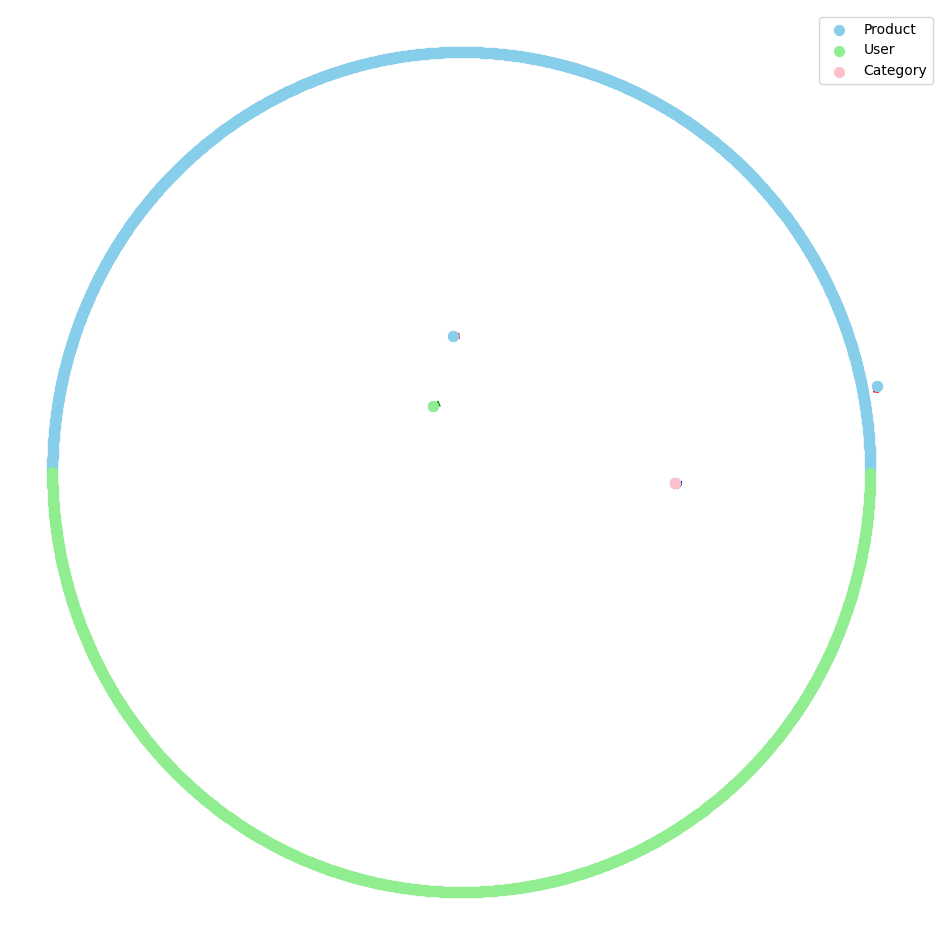

In [54]:
import networkx as nx
import matplotlib.pyplot as plt

# Create an empty directed graph
g = nx.DiGraph()

# Add nodes for 'Product'
for i in range(data['Product']['x'].size(0)):
    g.add_node(f'Product_{i}', type='Product', color='skyblue')

# Add nodes for 'User' and 'Category' assuming they are numbered consecutively
# and adjusting the numbers to fit your data
for i in range(data['User', 'Product', 'REVIEWS']['edge_index'].max().item() + 1):
    g.add_node(f'User_{i}', type='User', color='lightgreen')

for i in range(data['Product', 'Category', 'HAS_CATEGORY']['edge_index'][1].max().item() + 1):
    g.add_node(f'Category_{i}', type='Category', color='pink')

# Add edges for 'REVIEWS'
for i in range(data['User', 'Product', 'REVIEWS']['edge_index'].shape[1]):
    source = int(data['User', 'Product', 'REVIEWS']['edge_index'][0, i])
    target = int(data['User', 'Product', 'REVIEWS']['edge_index'][1, i])
    g.add_edge(f'User_{source}', f'Product_{target}', type='REVIEWS', color='green')

# Add edges for 'ALSO_BOUGHT'
for i in range(data['Product', 'Product', 'ALSO_BOUGHT']['edge_index'].shape[1]):
    source = int(data['Product', 'Product', 'ALSO_BOUGHT']['edge_index'][0, i])
    target = int(data['Product', 'Product', 'ALSO_BOUGHT']['edge_index'][1, i])
    g.add_edge(f'Product_{source}', f'Product_{target}', type='ALSO_BOUGHT', color='red')

# Add edges for 'HAS_CATEGORY'
for i in range(data['Product', 'Category', 'HAS_CATEGORY']['edge_index'].shape[1]):
    source = int(data['Product', 'Category', 'HAS_CATEGORY']['edge_index'][0, i])
    target = int(data['Product', 'Category', 'HAS_CATEGORY']['edge_index'][1, i])
    g.add_edge(f'Product_{source}', f'Category_{target}', type='HAS_CATEGORY', color='blue')


plt.figure(figsize=(12, 12))  # Increase the figure size

# Now we draw the graph
pos = nx.kamada_kawai_layout(g)  # This layout might give you a better spatial separation

# Draw nodes by type with specified colors
for node_type, color in [('Product', 'skyblue'), ('User', 'lightgreen'), ('Category', 'pink')]:
    nx.draw_networkx_nodes(
        g, 
        pos, 
        nodelist=[n for n, attr in g.nodes(data=True) if attr['type'] == node_type],
        node_color=color,
        label=node_type,
        node_size=50  # Adjust node size
    )

# Draw edges by type with specified colors and reduce the width to minimize clutter
for edge_type, color in [('REVIEWS', 'green'), ('ALSO_BOUGHT', 'red'), ('HAS_CATEGORY', 'blue')]:
    edges = [(u, v) for u, v, e in g.edges(data=True) if e['type'] == edge_type]
    nx.draw_networkx_edges(g, pos, edgelist=edges, edge_color=color, width=0.5)

# Draw node labels for a selection of nodes to reduce clutter
important_nodes = {n for n, d in g.degree() if d > 5}  # Example threshold for important nodes
nx.draw_networkx_labels(g, pos, labels={n: n for n in important_nodes}, font_size=8)

# Show the legend
plt.legend()

plt.axis('off')  # Turn off the axis
plt.show()
